In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as spo
from scipy.stats import norm 
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_california_housing
from sklearn import set_config
import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

# La distribución normal no se ajusta a todos los datos

Estamos acostumbrados a suponer que los datos siguen la distribución normal, pero hay dominios
donde esto es obviamente incorrecto. Por ejemplo, problemas donde las variables tienen un máximo y un valor mínimo impuesto por la naturaleza de los datos y donde las probabilidades están
sesgadas hacia uno de los extremos. En ese caso podemos ajustar una distribución más adecuada.
Por ejemplo, la distribución Gumbel se usa específicamente para ese tipo de datos. La función de
densidad de probabilidad de la distribución de Gumbel se define como:


$$
p(x;\mu,\beta) = \frac{1}{\beta} exp (-\frac{(x-\mu)}{\beta}) exp (-exp(-\frac{(x-\mu)}{\beta}))
$$

## Apartado a

Definimos la función de distribución de probabilidad como una función y representamos la distribución para diferentes parámetros. Adicionalmente, definiremos y representaremos también la función de la distribución acumulativa de la probabilidad.

In [3]:
def gumbel_pdf(x,loc,scale):
    z = np.exp(-(x-loc)/scale)
    return (1/scale) * z * np.exp(-z)
    
def gumbel_cdf(x,loc,scale):
    return np.exp(-np.exp(-(x-loc)/scale))

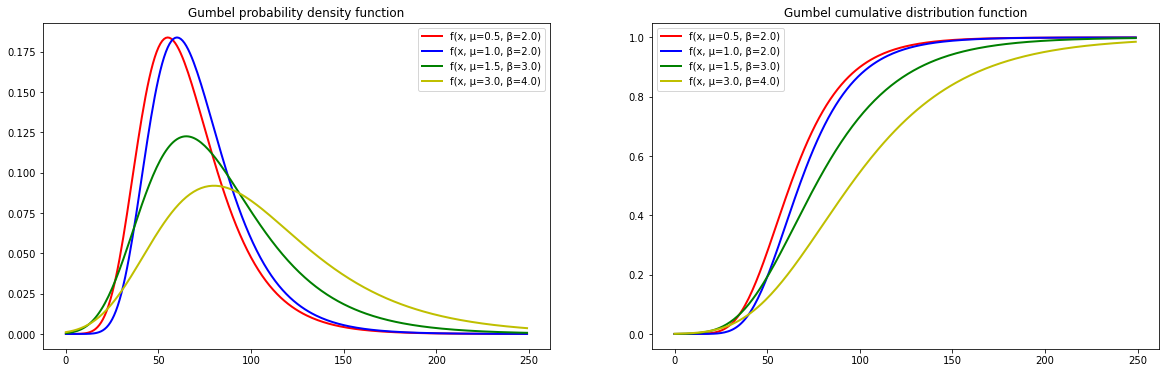

In [4]:
gumbel_data = np.arange(-5.0,20.0,0.1) # from -5 to 20 stepping 0.1

fig,ax = plt.subplots(1,2,figsize=(20,6));

# loc=0.5, scale=2.0
loc, scale = 0.5, 2.0
density_values = np.array( [gumbel_pdf(x,loc,scale) for x in gumbel_data] )
ax[0].plot(density_values, linewidth=2, color='r', label='f(x, μ=0.5, β=2.0)');
distribution_values = np.array( [gumbel_cdf(x,loc,scale) for x in gumbel_data] )
ax[1].plot(distribution_values, linewidth=2, color='r', label='f(x, μ=0.5, β=2.0)');

# loc=1.0, scale=2.0
loc, scale = 1.0, 2.0
density_values = np.array( [gumbel_pdf(x,loc,scale) for x in gumbel_data] )
ax[0].plot(density_values, linewidth=2, color='b', label='f(x, μ=1.0, β=2.0)');
distribution_values = np.array( [gumbel_cdf(x,loc,scale) for x in gumbel_data] )
ax[1].plot(distribution_values, linewidth=2, color='b', label='f(x, μ=1.0, β=2.0)');

# loc=1.5, scale=3.0
loc, scale = 1.5, 3.0
density_values = np.array( [gumbel_pdf(x,loc,scale) for x in gumbel_data] )
ax[0].plot(density_values, linewidth=2, color='g', label='f(x, μ=1.5, β=3.0)');
distribution_values = np.array( [gumbel_cdf(x,loc,scale) for x in gumbel_data] )
ax[1].plot(distribution_values, linewidth=2, color='g', label='f(x, μ=1.5, β=3.0)');

# loc=3.0, scale=4.0
loc, scale = 3.0, 4.0
density_values = np.array( [gumbel_pdf(x,loc,scale) for x in gumbel_data] )
ax[0].plot(density_values, linewidth=2, color='y', label='f(x, μ=3.0, β=4.0)');
distribution_values = np.array( [gumbel_cdf(x,loc,scale) for x in gumbel_data] )
ax[1].plot(distribution_values, linewidth=2, color='y', label='f(x, μ=3.0, β=4.0)');

# plots interface settings
ax[0].set_title('Gumbel probability density function');
ax[0].legend();

ax[1].set_title('Gumbel cumulative distribution function');
ax[1].legend();

## Apartado b

Vamos a ver los pasos para escribir el logaritmo de la verosimilitud negativa de una muestra y encontrar las derivadas parciales con respecto a los parámetros poblacionales.

Antes de empezar y para facilitar los cálculos, vamos a transformar mediante arimética la función de densidad de probabilidad de la distribución de Gumbel vista al inicio del notebook, por la siguiente:
$$
p(x;\mu,\beta) = \frac{1}{\beta} exp (-\frac{(x-\mu)}{\beta} - exp(-\frac{(x-\mu)}{\beta}))
$$

Primero de todo expresamos la distribución conjunta de las variables aleatorias:
$$
L_{n}(x;\mu,\lambda) = \frac{1}{\beta^{n}} exp (\sum_{i=1}^{n}(-\frac{x_{i}-\mu}{\beta} - e^{-\frac{x_{i}-\mu}{\beta}}))
$$

Sobre la expresión de la distribución conjunta, aplicamos el logaritmo negativo y obtenemos el logaritmo de la verosimilitud negativa:
$$
-ln L_{n}(x;\mu,\lambda) = n ln(\beta) - \sum_{i=1}^{n}(-\frac{x_{i}-\mu}{\beta} - e^{-\frac{x_{i}-\mu}{\beta}}) =
$$
$$
= n ln(\beta) + \sum_{i=1}^{n}\frac{x_{i}-\mu}{\beta} + \sum_{i=1}^{n}e^{-\frac{x_{i}-\mu}{\beta}}
$$

Una vez ya hemos encontrado el logaritmo de la verosimilitud negativa, n el siguiente paso vamos a encontrar la derivadas parciales para cada uno de los parámetros $\mu$  y $\lambda$, respectivamente:
$$
\frac{\partial [-ln L_{n}(x;\mu,\lambda)]}{\partial \mu} = -\frac{n}{\beta} + \frac{1}{\beta} \sum_{i=1}^{n}e^{-\frac{x_{i}-\mu}{\beta}} =
$$
$$
= \frac{\partial [-ln L_{n}(x;\mu,\lambda)]}{\partial \mu} = -\frac{1}{\beta}(n-\sum_{i=1}^{n}e^{-\frac{x_{i}-\mu}{\beta}})
$$
y por otro lado,
$$
\frac{\partial [-ln L_{n}(x;\mu,\lambda)]}{\partial \beta} = \frac{n}{\beta} - \sum_{i=1}^{n}\frac{x_{i}-\mu}{\beta^{2}} + \sum_{i=1}^{n}\frac{x_{i}-\mu}{\beta^{2}} e^{-\frac{x_{i}-\mu}{\beta}}
$$

## Apartado c

Las derivadas parciales nos dan como resultado un sistema de ecuaciones no lineales que se deben resolverse numéricamente. Por el mismo precio podemos ajustar directamente los parámetros de la distribución mediante optimización numérica. El método de optimización que usaremos es *Nelder-Mead*.

In [5]:
def gumbel_negative_log_pdf(p,xs):
    loc = p[0]
    scale = p[1]
    sum1 = len(xs) * np.log(scale)
    sum2 = 0
    sum3 = 0
    for x in xs:
        sum2 += ((x-loc)/scale)
        sum3 += (np.exp(-(x-loc)/scale))
    
    return (sum1+sum2+sum3)

Aplicaremos esta distribución al conjunto de datos California Housing que se puede descargar de la biblioteca *scikit-learn*.

In [6]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.325,41.0,6.984,1.024,322.0,2.556,37.88,-122.23,4.526
1,8.301,21.0,6.238,0.972,2401.0,2.110,37.86,-122.22,3.585
2,7.257,52.0,8.288,1.073,496.0,2.802,37.85,-122.24,3.521
3,5.643,52.0,5.817,1.073,558.0,2.548,37.85,-122.25,3.413
4,3.846,52.0,6.282,1.081,565.0,2.181,37.85,-122.25,3.422


Vamos a representar todas las variables del conjunto de datos para ver como se comportan sus respectivas distribuciones y si hay alguna que se comporte como la distribución de Gumbel.

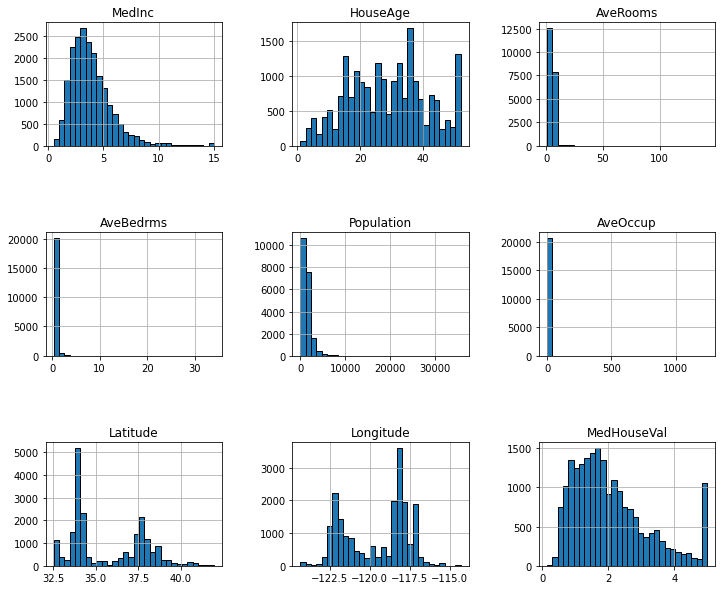

In [7]:
california_housing.frame.hist(figsize=(12,10), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.7, wspace=0.4);

Como podemos ver hay varias variables que se comportan como la distribución de Gumbel, de estas, nos quedaremos con las variables *MedInc* y *Population*. Antes de continuar, podaremos de nuestro conjunto de datos aquellos individuos con valores para la variable *Population* mayores o iguales a 7500. Como podemos ver en los histogramas inferiores, esto permite una representación mucho más clara de la distribución para esa variable.

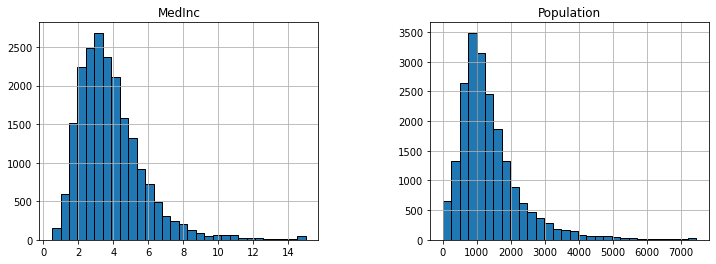

In [8]:
california_housing = california_housing.frame[california_housing.frame['Population']<7500];

california_housing[['MedInc','Population']].hist(figsize=(12,4), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.7, wspace=0.4);

El siguiente paso será utilizar la función de minimización para ajustar los parámetros de la verosimilitud logarítmica negativa de la distribución de Gumbel a los datos de estas variables.

In [9]:
medInc_data = np.array(california_housing['MedInc'])
medInc_data.sort()

medInc_result = spo.minimize(gumbel_negative_log_pdf, [0.5,0.5], args=(medInc_data), method='Nelder-Mead')

medInc_loc = medInc_result.x[0]
medInc_scale = medInc_result.x[1]
print('loc: ', medInc_loc)
print('scale: ', medInc_scale)

loc:  3.050226348576679
scale:  1.3706540376854601


In [10]:
population_data = np.array(california_housing['Population'])
population_data.sort()

population_result = spo.minimize(gumbel_negative_log_pdf, [0.5,0.5], args=(population_data), method='Nelder-Mead')

population_loc = population_result.x[0]
population_scale = population_result.x[1]
print('loc: ', population_loc)
print('scale: ', population_scale)

loc:  1000.9852127452752
scale:  628.5167615700095


## Apartado d

Vamos a representar, para cada una de las variables, la distribución de Gumbel para los parámetros ajustados, encontrados en el apartado anterior, contra el histograma normalizado de los datos.

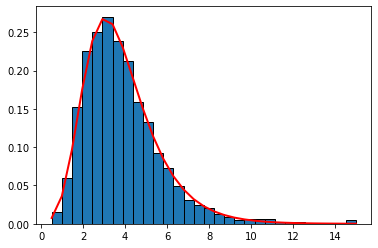

In [11]:
count, medInc_bins, ignored = plt.hist(medInc_data, density=True, bins=30, edgecolor='black')
plt.plot(medInc_bins, gumbel_pdf(medInc_bins, medInc_loc, medInc_scale), linewidth=2, color='r')

plt.show();

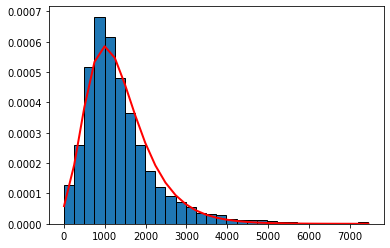

In [12]:
count, population_bins, ignored = plt.hist(population_data, density=True, bins=30, edgecolor='black')
plt.plot(population_bins, gumbel_pdf(population_bins,population_loc, population_scale), linewidth=2, color='r')

plt.show();

Podemos observar que tanto los parámetros encontrados para la variable *MedInc* como para la variable *Population* mediante optimización, se ajustan considerablemente bien a sus respectivos histogramas normalizados.

## Apartado e

Ahora calculamos la media y la varianza de las variables asumiendo que son gausianas y calculamos el logaritmo de la probabilidad que las distribuciones gausiana y Gumbel asignan a una muestra de los datos.

### MedInc variable

In [23]:
mean = medInc_data.mean()
std = medInc_data.std()
variance = math.pow(std,2)

print('Media:', mean, ' Varianza:', variance)

Media: 3.867300204290092  Varianza: 3.611033264986582


In [64]:
norm_probs = norm.pdf(medInc_bins)
gumbel_probs = gumbel_pdf(medInc_bins, medInc_loc, medInc_scale)

norm_log = np.sum(np.log(norm_probs))
gumbel_log = np.sum(np.log(gumbel_probs))

print(norm_log - gumbel_log)

-1111.4425594223885


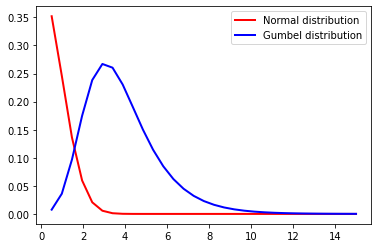

In [70]:
plt.plot(medInc_bins, norm.pdf(medInc_bins), linewidth=2, color='r', label='Normal distribution');
plt.plot(medInc_bins, gumbel_pdf(medInc_bins, medInc_loc, medInc_scale), linewidth=2, color='b', label='Gumbel distribution');
plt.legend();

Podemos ver como si hay una clara diferencia entre las probabilidades para esta variable respecto a la distribución Normal y la distribución Gumbel. El valor de la diferencia nos ha dado de -1111.44256 aproximadamente lo que representa que si, la diferencia entre ambas probabilidades es notoria.

### Population variable

In [66]:
mean = population_data.mean()
std = population_data.std()
variance = math.pow(std,2)

print('Media:', mean, ' Varianza:', variance)

Media: 1391.4142224816383  Varianza: 926038.6707758814


In [95]:
norm_probs = norm.pdf(population_bins)
gumbel_probs = gumbel_pdf(population_bins, population_loc, population_scale)

norm_probs_nozero = [] # we change the values smaller than 1e-323 in order to avoid problems with np.log function
for x in norm_probs:
    if x < 1e-323:
        x = 1e-323
    norm_probs_nozero.append(x)
    
norm_log = np.sum(np.log(norm_probs_nozero))
gumbel_log = np.sum(np.log(gumbel_probs))

print(norm_log - gumbel_log)

-21968.35755196077


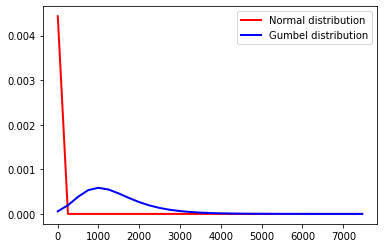

In [28]:
plt.plot(population_bins, norm.pdf(population_bins), linewidth=2, color='r', label='Normal distribution');
plt.plot(population_bins, gumbel_pdf(population_bins, population_loc, population_scale), linewidth=2, color='b', label='Gumbel distribution');
plt.legend();

Podemos ver como si hay una clara diferencia entre las probabilidades para esta variable respecto a la distribución Normal y la distribución Gumbel. El valor de la diferencia nos ha dado de -21968.357552 aproximadamente lo que representa que si, la diferencia entre ambas probabilidades es notoria.